# Keras.IO implementation (Run from here)

Implementation and processing of dataset as inspired by keras.io

In [1]:
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pylab as plt
try:
  from transformers import BertTokenizer, TFBertModel, BertConfig
except:
  !pip -q install transformers
  from transformers import BertTokenizer, TFBertModel, BertConfig
from tokenizers import BertWordPieceTokenizer


max_len = 384
configuration = BertConfig()  # default parameters and configuration for BERT

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
     |████████████████████████████████| 3.3 MB 58.9 MB/s 
     |████████████████████████████████| 61 kB 476 kB/s 


## Setting up the BERT tokenizer

In [2]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Read JSON data

In [3]:
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

4866048/4854279 [==============================] - 0s 0us/step


## Preprocess the data to SquadExamples
Source: https://keras.io/examples/nlp/text_extraction_with_bert/

In [4]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                all_answers = [_["text"] for _ in qa["answers"]]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)

In [5]:
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

87599 training points created.
10570 evaluation points created.


In [6]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations.
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class ExactMatch(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)  # index for hvor modellen tror svaret start
            end = np.argmax(end)      # -------------- || ----------------  ender
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

#model.save_weights('/content/drive/MyDrive/squadv1_trained_bert/checkpoint.h5')
#model.load_weights('/content/drive/MyDrive/squadv1_trained_bert/checkpoint.h5')

Mounted at /content/drive


## Differentiation example in TensorFlow
We use a so-called `GradientTape` which logs all operations on the TensorFlow variables in its scope. We can then ask it to differentiate one variable w.r.t. another using *autodiff*.

Hence `tape.gradient(y, [x1,x2])` would differentiate a variable `y` w.r.t. two variables individually `x1` and `x2`.

In [8]:
import tensorflow as tf

x = tf.Variable([[5.0]])
dense1 = tf.keras.layers.Dense(5, use_bias=False)
dense2 = tf.keras.layers.Dense(1, use_bias=False)

# Hvis du vil beregne flere gradienter på samme tape skal du sætte persistent=True
with tf.GradientTape(persistent=True) as tape:
  y = x*x + 2
  z = dense2(dense1(x))

print("dydx (x=5.0): {}".format(tape.gradient(y,x)))
print("dzdw (x=5.0, w): {}".format(tape.gradient(z, [dense1.weights, dense2.weights])))


dydx (x=5.0): [[10.]]
dzdw (x=5.0, w): [[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-3.828665  , -2.173947  , -0.9043181 ,  0.60455203,  3.7640083 ]],
      dtype=float32)>], [<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-3.7398195 ],
       [ 1.3444173 ],
       [-1.2001717 ],
       [-0.09094238],
       [ 3.5734653 ]], dtype=float32)>]]


## Intermediate layer models (final code starts here)
But do run the code from "Keras.IO implementation" and onwards.


In [11]:
from transformers.modeling_tf_utils import shape_list

def create_models_for_inner_layers():
    """
        Creates the models. The original function comes from "create_model" at
          https://keras.io/examples/nlp/text_extraction_with_bert/
        I then modified the function a lot to perform the same computations as 
        in the source code for TFBertEncoder.call at
          https://github.com/huggingface/transformers/blob/master/src/transformers/models/bert/modeling_tf_bert.py

        I take full credit for everything not existing (modified or unmodified)
        in those two sources. That includes the intermediate input-layers, 
        the keras.Models, and the hours of reverse-engineering required to put 
        it all together.

        Author: s184399 - Mikkel G. Jørgensen
    """
    #################
    # Inputs layers #
    #################
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='input_input_ids')
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='input_token_type_ids')
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name='input_attention_mask')
    token_embed = layers.Input(shape=(max_len, 768,), dtype=tf.float32, name='input_token_embeddings')
    original_input_layer = [input_ids, token_type_ids, attention_mask]
    embedding_input_layer = [token_embed, token_type_ids, attention_mask]
    intermediate_input_layer = embedding_input_layer
    top_layer_input = layers.Input(shape=(max_len, 768), dtype=tf.float32, name='top_layer_input')

    #####################
    # Obtain BERT model #
    #####################
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")  # TFBertModel
    bert_main_layer = bert_model.layers[0]   # TFBertMainLayer
    bert_encoder = bert_main_layer.encoder   # TFBertEncoder
    bert_embeddings = bert_main_layer.embeddings  # TFBertEmbeddings
    encoder_layers = bert_encoder.layer      # List[TFBertLayer]

    ##################
    # Some variables #
    ##################
    # This part is a slightly modified version of TFBertEncoder.call at: 
    # https://github.com/huggingface/transformers/blob/master/src/transformers/models/bert/modeling_tf_bert.py
    output_attentions = False # bert_encoder.output_attentions
    output_hidden_states = False # bert_encoder.output_hidden_states
    return_dict = False # bert_encoder.return_dict

    seq_length = 384
    past_key_values_length = 0

    attention_mask_shape = shape_list(attention_mask)
    mask_seq_length = seq_length + past_key_values_length
    extended_attention_mask = tf.reshape(
        attention_mask, (attention_mask_shape[0], 1, 1, attention_mask_shape[1])
    )
    extended_attention_mask = tf.cast(extended_attention_mask, dtype=tf.float32)
    one_cst = tf.constant(1.0, dtype=tf.float32)
    ten_thousand_cst = tf.constant(-10000.0, dtype=tf.float32)
    extended_attention_mask = tf.multiply(tf.subtract(one_cst, extended_attention_mask), ten_thousand_cst)
    encoder_extended_attention_mask = None

    #extended_attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]
    #extended_attention_mask = tf.cast(extended_attention_mask, tf.float32)
    #extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0  # ??
    head_mask = [None] * len(encoder_layers)

    ###########################
    # Construct the model top #
    ###########################
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(top_layer_input)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(top_layer_input)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    top_layer_model = keras.Model(
        inputs=top_layer_input,
        outputs=[start_probs, end_probs],
        name='top_layer_model'
    )

    ################################
    # Construct the input embedder #
    ################################
    input_embedder = tf.keras.Model(
        original_input_layer, 
        bert_embeddings(
            input_ids=input_ids,
            token_type_ids=token_type_ids
        ),
        name='embedder'
    )

    #########################
    # Construct the encoder #
    #########################
    output_embedding = bert_encoder(
        hidden_states=token_embed,
        attention_mask=extended_attention_mask,
        head_mask=head_mask,
        output_attentions=output_attentions, 
        past_key_values=None,
        encoder_attention_mask=None,
        encoder_hidden_states=None,
        training=False,
        use_cache=True,
        output_hidden_states=False,
        return_dict=True
    )[0]
    embedding_based_model = keras.Model(
        inputs=embedding_input_layer,
        outputs=top_layer_model(output_embedding),
        name='embedding_based_model'
    )

    ############################
    # Construct the full model #
    ############################
    bert_embedding_original = bert_model(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]
    full_model = keras.Model(
        inputs=original_input_layer,
        outputs=top_layer_model(bert_embedding_original),
        name='full_model'
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    full_model.compile(optimizer=optimizer, loss=[loss, loss])  # The model we'll train.

    ######################################
    # Construct the partial model tuples #
    ###################################### 
    # Rename layer parts
    for i, layer_module in enumerate(encoder_layers):
        layer_module.attention._name = "attention_{}".format(i)
        layer_module.intermediate._name = "intermediate_{}".format(i)
        layer_module.bert_output._name = "output_{}".format(i)

    partial_models = []
    hidden_states = input_embedder(original_input_layer)
    for i, layer_module in enumerate(encoder_layers[:-1]):
        # Call layer on previous hidden state and construct a model
        hidden_states = layer_module(
            hidden_states, 
            attention_mask=extended_attention_mask, 
            head_mask=head_mask[i],
            output_attentions=output_attentions, 
            past_key_value=None,
            encoder_attention_mask=None,
            encoder_hidden_states=None,
            training=False
        )[0]
        model_pt1 = tf.keras.Model(
            inputs=original_input_layer,
            outputs=hidden_states
        )
        # Construct the second part of the model
        intermediate_output = token_embed
        for j, remaining_layer in enumerate(encoder_layers[i+1:]):
            intermediate_output = remaining_layer(
                intermediate_output, 
                attention_mask=extended_attention_mask, 
                head_mask=head_mask[j+i+1],
                output_attentions=output_attentions, 
                past_key_value=None,
                encoder_attention_mask=None,
                encoder_hidden_states=None,
                training=False
            )[0]
        model_pt2 = tf.keras.Model(
            inputs=intermediate_input_layer,
            outputs=top_layer_model(intermediate_output)
        )
        partial_models.append((model_pt1, model_pt2))

    return full_model, input_embedder, embedding_based_model, partial_models, top_layer_model


use_tpu = True #
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        full_model, input_embedder, embedding_based_model, partial_models, top_layer_model = create_models_for_inner_layers()
else:
      full_model, input_embedder, embedding_based_model, partial_models, top_layer_model = create_models_for_inner_layers()


train_models = True
#####################################################################
# Unit test: Do combined partial models evaluate as the full model? #
#####################################################################
test_input = [x_train[0][0:5], x_train[1][0:5], x_train[2][0:5]]


full_model_pred = full_model(test_input)
for model_pt1, model_pt2 in partial_models:
    assert np.all(np.isclose(
        full_model_pred,
        model_pt2([model_pt1(test_input), test_input[1], test_input[2]])
    ))

############################################
# Unit test: Do the models train together? #
############################################
exact_match_callback = ExactMatch(x_eval, y_eval)

if train_models:
    hist = full_model.fit(
        x_train,
        y_train,
        epochs=1,
        verbose=1,
        batch_size=8, # 64 batch måske lige lovligt meget
        callbacks=[exact_match_callback],
    )
    full_model.save_weights('drive/MyDrive/squadv1_trained_bert/checkpoint.h5')
else:
    full_model.load_weights('drive/MyDrive/squadv1_trained_bert/checkpoint.h5')

embed_test_input = [input_embedder(test_input), x_train[1][0:5], x_train[2][0:5]]

full_model_output = full_model(test_input)

assert np.all(np.isclose(
    full_model_output,
    embedding_based_model(embed_test_input)
))

for model_pt1, model_pt2 in partial_models:
    assert np.all(np.isclose(
        full_model_output,
        model_pt2([model_pt1(test_input), test_input[1], test_input[2]])
    ))



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.169.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.169.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


    6/10767 [..............................] - ETA: 12:38 - loss: 10.8625 - top_layer_model_loss: 5.6073 - top_layer_model_1_loss: 5.2553WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0059s vs `on_train_batch_end` time: 7.1568s). Check your callbacks.


10767/10767 [==============================] - ETA: 0s - loss: 2.5377 - top_layer_model_loss: 1.3291 - top_layer_model_1_loss: 1.2086

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 384) dtype=int64>]



epoch=1, exact match score=0.74
10767/10767 [==============================] - 864s 74ms/step - loss: 2.5377 - top_layer_model_loss: 1.3291 - top_layer_model_1_loss: 1.2086


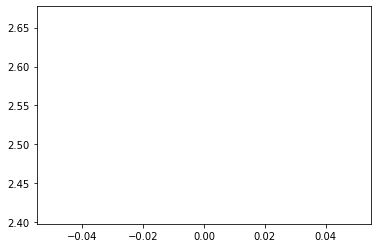

In [12]:
hist.history['loss']

plt.plot(hist.history['loss'])

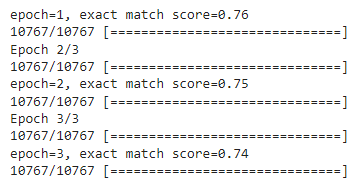

## Integrated Gradients & Visualizations

Inspirered by: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients#compute_gradients

Visualization Source: https://github.com/ankurtaly/Integrated-Gradients/blob/master/howto.md#visualizing-the-attributions

In [13]:
def integrate_gradients_layer(baseline,
                              input_data,
                              input_target,
                              input_data_idx = 0,
                              steps = 50,
                              PreLayers = None, 
                              PostLayers = None):
  if PreLayers is None or PostLayers is None:
    print("Please the embedding layer as well as the remaining model")
    return

  if (len(input_data) != 3):
    print("Please send the x-eval as you would the model.")
    return
  
  #print("\tEntered sub-function ...")

  alphas = tf.linspace(0.0, 1.0, steps+1)
  input_embeds = PreLayers([input_data[0][input_data_idx:input_data_idx+1],
                              input_data[1][input_data_idx:input_data_idx+1],
                              input_data[2][input_data_idx:input_data_idx+1]])

  embeddings = interpolate_embeddings(baseline, input_embeds[0], alphas)

  grad_comp_input = get_input(input_data[1:], input_data_idx, steps)

  grads = compute_gradients(embeddings, grad_comp_input, input_target, input_data_idx, PostLayers)

  # approximate the integral
  grads = integral_approximation(grads)

  # Normalize
  grads = tf.linalg.normalize(tf.norm(tf.multiply((input_embeds - baseline), grads), axis=2), ord=1, axis=1)[0]

  return grads

def integrate_gradients_all(input_data,
                            input_target,
                            input_data_idx = 0,
                            steps = 50, 
                            models = None):
  if models is None:
    print("Models are not defined!")
    return
  
  bl = tf.zeros((max_len, 768))

  grads = []

  for model_pt1, model_pt2 in partial_models:
    grad = integrate_gradients_layer(bl, input_data, input_target, input_data_idx, steps, model_pt1, model_pt2)

    grads.append(grad)
  
  return grads

def interpolate_embeddings(baseline,
                           embedding,
                           alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  embeddings_x = tf.expand_dims(embedding, axis=0)
  delta = embeddings_x - baseline_x
  embeddings = baseline_x + alphas_x * delta
  return embeddings

def compute_gradients(embeddings,
                      input,
                      targets,
                      input_idx,
                      embed_based_model):
  assert len(input) == 2
  with tf.GradientTape(persistent=True) as tape:
    
    tape.watch(embeddings) # Vi sikrer os, at det holder øje!
    outputs = embed_based_model([embeddings, input[0], input[1]])

    probs_start = outputs[0][:,targets[0][input_idx]] #[:, y_eval[0][0]]   # Start token(s) probability 
    probs_end = outputs[1][:,targets[1][input_idx]] #[:, y_eval[1][0]]     # End token(s) probability

    grads_start = tape.gradient(probs_start, embeddings) 
    grads_end = tape.gradient(probs_end, embeddings)

    grads = tf.math.add(grads_start, grads_end)
  return grads

def get_input(input,
              idx, 
              steps):
  dims = steps+1
  inp1 = []
  inp2 = []
  for i in range(dims):
    inp1.append(input[0][idx])
    inp2.append(input[1][idx])
  return tf.constant(inp1), tf.constant(inp2)

def summarise(attributions):
  attributions = tf.reduce_sum(attributions, axis=-1)
  attributions = attributions / tf.norm(attributions)
  return attributions

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

from IPython.display import display, HTML

# Source: https://github.com/ankurtaly/Integrated-Gradients/blob/master/howto.md#visualizing-the-attributions
def visualize_token_attrs(tokens, attrs):
  """
  Visualize attributions for given set of tokens.
  Args:
  - tokens: An array of tokens
  - attrs: An array of attributions, of same size as 'tokens',
    with attrs[i] being the attribution to tokens[i]
  
  Returns:
  - visualization: An IPython.core.display.HTML object showing
    tokens color-coded based on strength of their attribution.
  """
  
  def get_color(attr):
    if attr > 0:
      r = int(128*attr) + 127
      g = 128 - int(64*attr)
      b = 128 - int(64*attr) 
    else:
      r = 128 + int(64*attr)
      g = 128 + int(64*attr) 
      b = int(-128*attr) + 127
    return r,g,b

  # normalize attributions for visualization.
  bound = max(abs(tf.reduce_max(attrs)), abs(tf.reduce_min(attrs)))
  attrs = (attrs/bound)[0]
  html_text = ""
  for i, tok in enumerate(tokens):
    if tok == 0:
      continue
    r,g,b = get_color(attrs[i])
    html_text += " <span style='color:rgb(%d,%d,%d)'>%s</span>" % (r, g, b, tok)
  return HTML(html_text)

def token_to_words(tokens):
  text = []
  for i, tok in enumerate(tokens):
    if tok == 101:
      text.append('[CLS]')
    elif tok == 102:
      text.append('[SEP]')
    else:
      text.append(tokenizer.decode([tok]))
  return text


####################
###  UNIT TESTS  ###
####################

alphas = tf.linspace(0.0, 1.0, 4)

# interpolation unit test
test_embeds = interpolate_embeddings([0.0], [[1.0],[1.0],[1.0]], alphas)
assert np.all(np.isclose(test_embeds.numpy(), np.array([[[[0.0]], [[1/3.0]], [[2/3.0]], [[1.0]]]])))

# compute_gradients unit test

input_ids = layers.Input(shape=(3,1), dtype=tf.float32, name='input_input_ids')
token_type_ids = layers.Input(shape=(3,), dtype=tf.float32, name='input_token_type_ids')
attention_mask = layers.Input(shape=(3,), dtype=tf.float32, name='input_attention_mask')
original_input_layer = [input_ids, token_type_ids, attention_mask]

start_layers = tf.keras.layers.Dense(1, None, False)(input_ids)
start_layers = tf.keras.layers.Flatten()(start_layers)

end_layers = tf.keras.layers.Dense(1, None, False)(input_ids)
end_layers = tf.keras.layers.Flatten()(end_layers)

test_model = tf.keras.Model(inputs=original_input_layer, outputs=[start_layers, end_layers])
test_model([test_embeds, tf.constant([[3.0,3.0,3.0]]), tf.constant([[1.0,1.0,1.0]])])
test_model.layers[1].weights[0].assign(tf.constant([[3.0]]))
test_model.layers[2].weights[0].assign(tf.constant([[2.0]]))
# print("FM: ", test_model([test_embeds, tf.constant([[3.0,3.0,3.0]]), tf.constant([[1.0,1.0,1.0]])]))

gradsTest = compute_gradients(test_embeds,
                                [tf.constant([[3.0,3.0,3.0]]), tf.constant([[1.0,1.0,1.0]])],
                                tf.constant([[1],[2]]), 
                                0, 
                                test_model)
# print("Grads: ", gradsTest)
assert np.all(gradsTest.numpy() == np.array([[[0.0],[3.0],[2.0]]]))



# Integral Appoximation unit test
# print(integral_approximation(gradsTest))

assert np.all(tf.equal(integral_approximation(gradsTest), tf.constant([[0.0],[3.0],[2.0]])))

## Top 5 Attributions (summed grad):

In [14]:
import numpy as np

def find_answer_span_tokens(y_eval_data, index):
  """
    Returns indices of answer span
  """
  return np.arange(y_eval_data[0][index], y_eval_data[1][index]+1)

def find_query_words_in_passage(x_eval, index):
  """
    Returns index of query words
  """
  passage = x_eval[0][index]
  start, end = np.argwhere(passage==102)
  query_toks = passage[start[0]+1:end[0]]
  passage = passage[0: start[0]]

  def predicate(passage):
    
    ans = np.zeros(passage.shape, dtype=np.bool)

    for i, e in enumerate(passage):
      ans[i] = e in query_toks

    return ans

  return np.argwhere(predicate(passage)).ravel()

def find_support_tokens(answer_start, answer_end, passage):
  start, end = np.argwhere(passage==102)
  passage = passage[0: start[0]]

  first_span_start = max(0, answer_start-5)
  last_span_end = min(len(passage)-1, answer_end+5)

  
  return np.hstack((np.arange(first_span_start,answer_start),
                    np.arange(answer_end+1,last_span_end+1)))


def get_token_types(x_eval, y_eval, index):
  answer_tokens = find_answer_span_tokens(y_eval, index)
  query_tokens = find_query_words_in_passage(x_eval, index)
  support_tokens = find_support_tokens(y_eval[0][index], 
                                       y_eval[1][index], 
                                       x_eval[0][index])
  
  return answer_tokens, query_tokens, support_tokens

def find_top_five_attributions(grad):
  
  l_top_start = []

  for i in range(len(grad)):
    
    l_top_start.append(np.argsort(grad[i][0])[-5:])
  
  return l_top_start

def find_aqs_counts(t5sgs, answer_toks_idxs, support_toks_idxs, query_toks_idxs):

  def predi_fun(passage, pattern):
    ans = np.zeros(pattern.shape, dtype=np.bool)

    for i, e in enumerate(pattern):
      ans[i] = e in passage
  
    return ans

  SCount = []

  for i in range(len(t5sgs)):
    sg = t5sgs[i]

    numSA = np.sum(predi_fun(sg, answer_toks_idxs))       # Answers in top 5
    numSQ = np.sum(predi_fun(sg, support_toks_idxs))      # Queries in top 5 
    numSS = np.sum(predi_fun(sg, query_toks_idxs))        # Support in top 5

    SCount.append((numSA, numSQ, numSS))
  
  return SCount

def get_aqs_percentages(sCount, a_length, q_length, s_length):
  percentages_s = []

  for s in sCount:

    perSA = s[0]/a_length
    perSQ = s[1]/q_length
    perSS = s[2]/s_length

    percentages_s.append((perSA, perSQ, perSS))
  
  return percentages_s



## Testing

In [15]:
# NEW VERSION (Single)

idx = 0
steps = 10
grads = integrate_gradients_all(x_eval, y_eval, idx, steps, partial_models)

words = token_to_words(x_eval[0][idx])

for i in range(len(grads)):

  print("==" * 10)
  print("LAYER " + str(i+1) + "->:")
  print("==" * 10)
  print("\tToken Attributions:")
  display(visualize_token_attrs(words, grads[i]))

print("True Answer:")
print(token_to_words(x_eval[0][idx][y_eval[0][idx]:y_eval[1][idx]+1]))
print("Token position for start/end")
print(y_eval[0][idx], y_eval[1][idx])
o = full_model([x_eval[0][idx:idx+1], x_eval[1][idx:idx+1], x_eval[2][idx:idx+1]])
print("Model S/E predictions:")
print(tf.math.argmax(o[0], axis=-1), " - ", tf.math.argmax(o[1], axis=-1))
print("Model Answer:")
print(token_to_words(x_eval[0][idx][tf.math.argmax(o[0], axis=-1)[0]:tf.math.argmax(o[1], axis=-1)[0]+1]))

LAYER 1->:
	Token Attributions:


LAYER 2->:
	Token Attributions:


LAYER 3->:
	Token Attributions:


LAYER 4->:
	Token Attributions:


LAYER 5->:
	Token Attributions:


LAYER 6->:
	Token Attributions:


LAYER 7->:
	Token Attributions:


LAYER 8->:
	Token Attributions:


LAYER 9->:
	Token Attributions:


LAYER 10->:
	Token Attributions:


LAYER 11->:
	Token Attributions:


True Answer:
['denver', 'broncos']
Token position for start/end
34 35
Model S/E predictions:
tf.Tensor([34], shape=(1,), dtype=int64)  -  tf.Tensor([35], shape=(1,), dtype=int64)
Model Answer:
['denver', 'broncos']


In [16]:
a, q, s = get_token_types(x_eval, y_eval, idx)
t5s = find_top_five_attributions(grads)
print(t5s)
sCount = find_aqs_counts(t5s, a, s, q)
ps = get_aqs_percentages(sCount, len(a), len(q), len(s))
print(ps)

[array([31,  0, 34, 33, 35]), array([161,  31,  34,  33,  35]), array([46, 45, 33, 35, 34]), array([45, 33, 46, 34, 35]), array([161,  33, 159,  34,  35]), array([ 46, 159,  45,  34,  35]), array([ 46, 159,  45,  34,  35]), array([159,  46,  45,  35,  34]), array([ 45, 161, 159,  35,  34]), array([32, 45, 46, 34, 35]), array([43, 34, 45, 35, 46])]
[(1.0, 0.06451612903225806, 0.1), (1.0, 0.06451612903225806, 0.1), (1.0, 0.03225806451612903, 0.0), (1.0, 0.03225806451612903, 0.0), (1.0, 0.03225806451612903, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.03225806451612903, 0.0), (1.0, 0.0, 0.0)]


In [ ]:
# NEWER VERSION (num samples)

steps = 10
num = 50

pss = []

for i in np.arange(start=0, stop=len(x_eval[0]), step=len(x_eval[0])/num, dtype=np.int):
  print("Integrated Gradients on x_eval index " + str(i) + "!")
  sgs = integrate_gradients_all(x_eval, y_eval, i, steps, partial_models)
  a, q, s = get_token_types(x_eval, y_eval, i)
  t5s = find_top_five_attributions(sgs)
  sCount = find_aqs_counts(t5s, a, s, q)
  ps = get_aqs_percentages(sCount, len(a), len(q), len(s))
  pss.append(ps)

print(pss)

In [ ]:

layer_percentage = np.zeros((11, 3))

for layer_percentages in pss:
  for i, (pa, ps, pq) in enumerate(layer_percentages):
    layer_percentage[i][0] += pa
    layer_percentage[i][1] += ps
    layer_percentage[i][2] += pq

for i in range(len(layer_percentage)):
  layer_percentage[i][0] /= num
  layer_percentage[i][1] /= num
  layer_percentage[i][2] /= num

for i, per in enumerate(layer_percentage):
  print("LAYER ", str(i+1), " PERCENTAGES (answer, support, query):")
  print(" ", per)